# Práctica: Filtrado molecular: ADME y criterios de similitud 'lead-likeness'

## Teoría

### **Farmacocinética**

La farmacocinética es el estudio de lo que le sucede a un compuesto en un organismo durante un período de tiempo ([Grogan S, Preuss CV. Pharmacokinetics, 2022](https://www.ncbi.nlm.nih.gov/books/NBK557744/) ). Se divide en cuatro pasos: **A**absorción, **D**distribución, **M**metabolismo y **E**xcreción ([ADME](https://www.ncbi.nlm.nih .gov/pmc/articles/PMC4110820/)). En ocasiones también se incluye **T**oxicología (ADMET) y **L**iberación (LADME).

 
<img src="img/ADME-es.jpg" alt="ADME" width="800"/>

*Figura 1*. Pasos que componen la farmacocinética. De: [Somvanshi, Kharat, Jadhav, Thorat y Townley, 2021](https://doi.org/10.1016/B978-0-323-85050-6.00007-4)

   * **Absorción:** Se refiere a la cantidad y el tiempo que tarda un compuesto o sustancia en ingresar a la circulación sistémica desde el sitio de administración. Depende de múltiples factores como la capacidad del compuesto para penetrar la pared intestinal, la solubilidad del compuesto, el tiempo de vaciado gástrico, la estabilidad química del compuesto en el estómago, entre otros.
   * **Distribución:** Se refiere a cómo una sustancia se distribuye por todo el cuerpo. Depende de la difusión y la convección, que pueden verse influidas por la polaridad, el tamaño o la capacidad de unión del fármaco, el estado de líquidos del paciente o la constitución corporal del individuo. Es muy importante lograr la concentración eficaz del fármaco en el sitio del receptor porque, para ser eficaz, un medicamento debe llegar a su destino compartimental designado.
   * **Metabolismo:** Se refiere al procesamiento del fármaco por parte del cuerpo en compuestos posteriores. También puede ser convertir un fármaco en sustancias más solubles en agua para que sea más fácil de excretar o, en el caso de los profármacos, se requiere el metabolismo para convertir el fármaco en metabolitos activos.
   * **Excreción:** Se refiere al proceso por el cual la droga es eliminada del organismo. Generalmente los riñones son conductos de excreción por filtración pasiva en los glomérulos o secreción en los túbulos.

### **Regla de cinco de Lipinski:**

La regla de cinco de Lipinski es una forma de descartar compuestos con probables problemas de absorción. Esta regla establece que la mala absorción o penetración de un fármaco es más probable cuando la estructura química cumple con dos o más de los [siguientes criterios:](https://www.sciencedirect.com/science/article/pii/B008045044X001474)
1. El peso molecular (MW) es superior a 500.
2. El valor de log P calculado es superior a 5.
3. Hay más de 5 donantes de enlaces de hidrógeno (–NH–, –OH).
4. El número de aceptores de enlaces de hidrógeno (–N ¼ , –O–) es mayor que 10.

Es importante saber que la regla de cinco no categoriza definitivamente todos los compuestos bien y mal absorbidos, aunque es simple, rápida y proporciona un grado razonable de clasificación.

## Planteamiento del problema

Para una investigación de un nuevo fármaco queremos saber si realmente es absorbido por el cuerpo, si es capaz de cruzar ciertas barreras para llegar a su objetivo, cómo se metaboliza y cómo se excreta del cuerpo. De esta manera los médicos tendrán mayor flexibilidad en la prescripción y administración de medicamentos, brindando así mayor beneficio con menor riesgo y haciendo los ajustes necesarios, dada la variada fisiología y estilos de vida de los pacientes.

Para conocer la absorción de los compuestos utilizaremos herramientas bioinformáticas para poder calcular la regla de cinco de Lipinski y luego calcularemos unos estadísticos para graficarlos y analizarlos.

## Importar las bibliotecas necesarias

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit.Chem import Draw
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from math import pi
import os
from pathlib import Path

## Cargar conjunto de datos de P49841
El conjunto de datos contiene los compuestos bioactivos contra la glucógeno sintasa quinasa-3 beta que construimos en el tutorial 2.1_Dataframes.
Lo primero que vamos a hacer es importar la base de datos, tenemos que crear un `directorio raíz` (`ROOT_DIR`) para poder navegar hasta el archivo.

In [2]:
current_directory = os.getcwd()
ROOT_DIR = Path(current_directory).parent
uniprot_id = 'P49841'
print('Directorio raíz:', ROOT_DIR)
df_output = pd.read_csv(f'{ROOT_DIR}/2_PART_TWO/data/compounds_P49841_full.csv')
df_output.head()

Directorio raíz: C:\Users\caramirezs\My Drive\Python\DS-for-DD


,molecule_chembl_id,pchembl_value,smiles,ROMol
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...


## La regla de cinco de Lipinski

La siguiente función nos permitirá calcular las propiedades químicas de la regla de cinco de Lipinski teniendo como entrada las SONRISAS. Luego se definirán las condiciones de la regla de cinco y finalmente tendremos información de si se viola la regla de cinco.

In [3]:
def Ro5(df):
    
    smi = df['smiles']
    m = Chem.MolFromSmiles(smi)
    
    # Calcular la regla de cinco propiedades químicas
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Regla de cinco condiciones
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    
    # # Crear una fila de pandas para resultados de condiciones con valores e información sobre si se viola la regla de cinco
    return pd.Series([MW, HBA, HBD, LogP, 'yes']) if conditions.count(True) >= 3 else pd.Series([MW, HBA, HBD, LogP, 'no'])

Ahora vamos a aplicar la regla de 5 de Lipinski a nuestro conjunto de datos

In [4]:
df_rule5 = df_output.apply(Ro5, axis=1)
# Nombre de las columnas condition column
df_rule5.columns= ['MW', 'HBA', 'HBD', 'LogP', 'rule_of_five_conform']
df_rule5.head()
# regla5_df = comp_def.apply(df_regla_5, eje=1)
# print('# de compuestos en conjunto de datos sin filtrar:', len(comp_def))

,MW,HBA,HBD,LogP,rule_of_five_conform
0,514.165248,6,1,3.3616,yes
1,407.186987,7,3,2.4397,yes
2,392.196074,8,0,1.9610,yes
3,484.211055,7,1,3.2107,yes
4,392.196074,8,0,1.9610,yes


In [5]:
df_molecule = df_output.join(df_rule5)
df_molecule.head()

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes


# de compuestos: 2657
# de compuestos en conjunto de datos filtrados: 2477
# de compuestos que no cumplen con la regla de cinco de Lipinski: 180
rule_of_five_conform
yes    2477
no      180
Name: count, dtype: int64


<Axes: xlabel='rule_of_five_conform'>

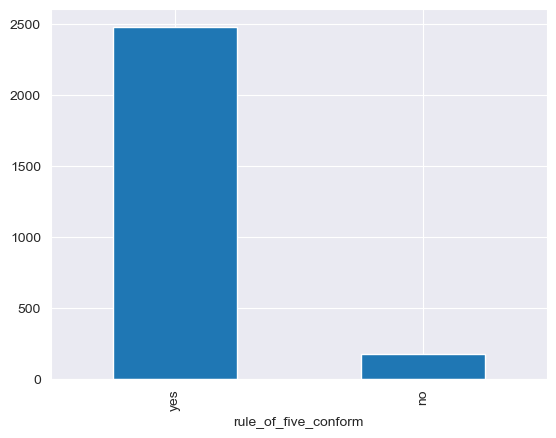

In [6]:
# Eliminar filas vacías --> regla de cinco
fil_df = df_molecule[df_molecule['rule_of_five_conform']=='yes']
print('# de compuestos:', len(df_molecule))
print('# de compuestos en conjunto de datos filtrados:', len(fil_df))
print("# de compuestos que no cumplen con la regla de cinco de Lipinski:", (len(df_molecule)-len(fil_df)))
print(df_molecule.rule_of_five_conform.value_counts())
df_molecule.rule_of_five_conform.value_counts().plot.bar()

In [7]:
df_molecule.to_csv('data/compounds_P49841_lipinski.csv', index=False)

## Graficar las propiedades de la regla de cinco por molécula como gráficos de barras.

In [8]:
# Importar el conjunto de datos
lipinski_comp = pd.read_csv('data/compounds_P49841_lipinski.csv')
lipinski_comp.head(10)

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
5,CHEMBL2386090,9.70,O=C1NC(=O)C(c2cn3c4c(cccc24)CN(C(=O)c2cnccn2)C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,489.143704,7,1,3.4007,yes
6,CHEMBL3963605,9.70,Nc1ncc(-c2ccccc2)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,389.196408,7,3,2.3006,yes
7,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,380.176088,7,0,2.0915,yes
8,CHEMBL3942619,9.70,COc1ccc(-c2cnc(N)c(C(=O)Nc3cnccc3N3CCC(N)CC3)n...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,419.206973,8,3,2.3092,yes
9,CHEMBL3957649,9.70,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,393.171336,7,3,1.9218,yes


In [9]:
comp_5_lipinski = lipinski_comp.iloc[:5]
comp_5_lipinski

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes


#### Ahora haremos el gráfico de barras.

In [10]:
ro5_properties = {
    "MW": (500, "molecular weight (Da)"),
    "HBA": (10, "# HBA"),
    "HBD": (5, "# HBD"),
    "LogP": (5, "logP"),
}

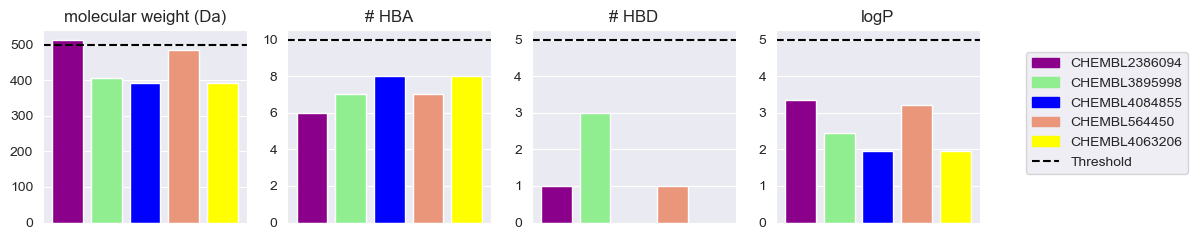

In [11]:
# Comience el marco de la trama 1x4
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(comp_5_lipinski) + 1)
colors = ["DarkMagenta", "LightGreen", "blue", "DarkSalmon", "yellow"]

# Crear subparcelas
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([0, 1, 2, 3, 4], comp_5_lipinski [key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Agregar leyenda
legend_elements = [mpatches.Patch(color=colors[index], label=row["molecule_chembl_id"]) for index, row in comp_5_lipinski.iterrows()]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Ajustar subparcelas y leyendas en la figura
plt.tight_layout()
plt.show()

## Graficar las propiedades de la regla de cinco por molécula como diagramas de dispersión.

<Figure size 2000x2000 with 0 Axes>

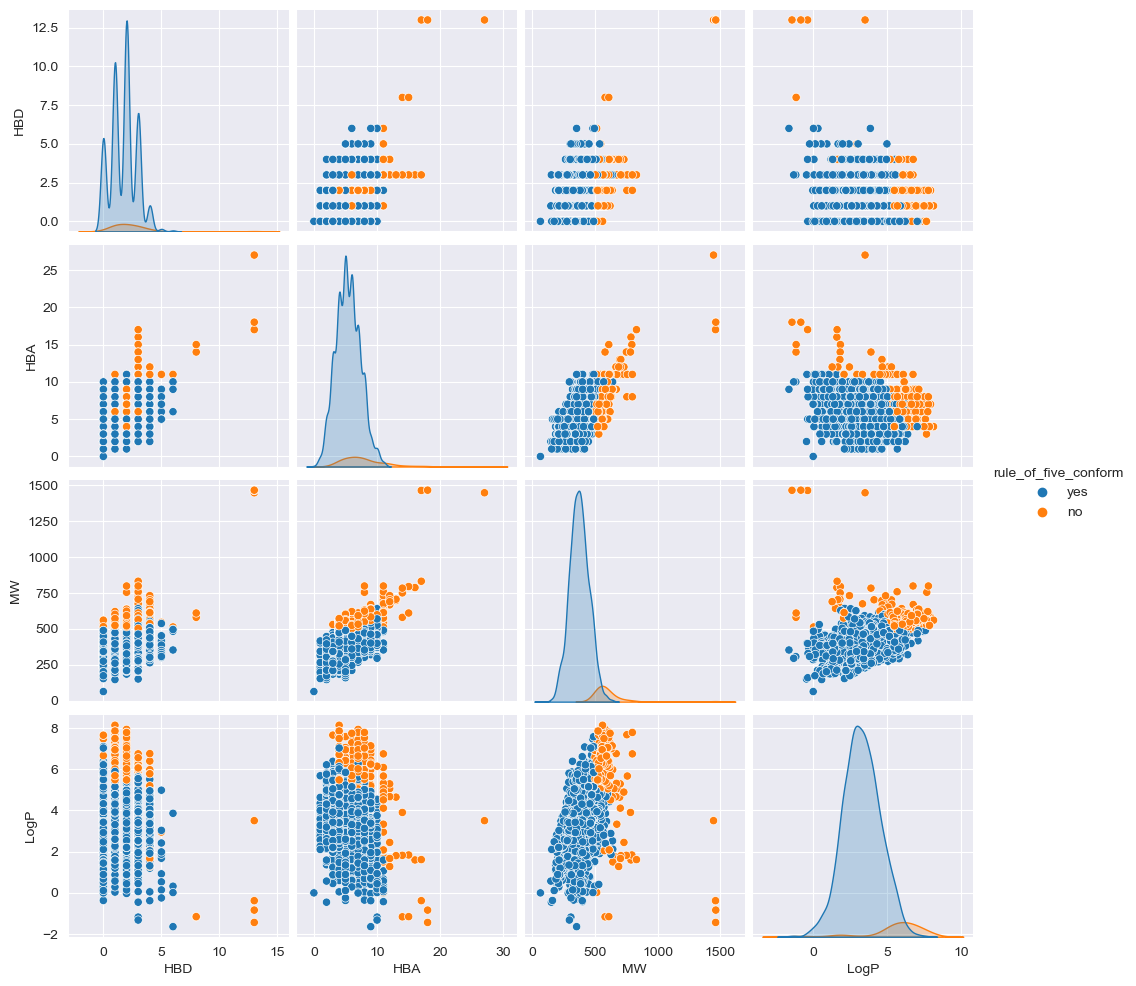

In [12]:
fig = plt.figure(figsize=(20, 20))
ax = sns.pairplot(data=lipinski_comp, vars=['HBD', 'HBA', 'MW', 'LogP'], hue='rule_of_five_conform')
plt.show()
plt.close()

## Graficar las propiedades de la regla de cinco por molécula como gráfico de radar.

In [13]:
# Importar el conjunto de datos
lipinski_comp = pd.read_csv('data/compounds_P49841_lipinski.csv')
lipinski_comp.head(10)

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
5,CHEMBL2386090,9.70,O=C1NC(=O)C(c2cn3c4c(cccc24)CN(C(=O)c2cnccn2)C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,489.143704,7,1,3.4007,yes
6,CHEMBL3963605,9.70,Nc1ncc(-c2ccccc2)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,389.196408,7,3,2.3006,yes
7,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,380.176088,7,0,2.0915,yes
8,CHEMBL3942619,9.70,COc1ccc(-c2cnc(N)c(C(=O)Nc3cnccc3N3CCC(N)CC3)n...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,419.206973,8,3,2.3092,yes
9,CHEMBL3957649,9.70,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,393.171336,7,3,1.9218,yes


Debido a que las propiedades químicas de la regla de cinco están en diferentes órdenes de magnitud, necesitamos transformarlas para poder visualizarlas en el diagrama de radar. En este caso, la mejor forma es transformar los datos de tal manera que los límites de validación sean todos 5:

- NW original: 500 Da - NW modificado: 5 - regla: NW/100 (Molecular weight (Da)/100)
- HBA original: 10 - HBA modificado: 5 - regla: HBA/2 (# H-bond acceptors/2)
- HBD original: 5 - no cambia (# H-bond donors)
- LogP original: 5 - no cambia (LogP)

Por tanto, vamos a transformar las columnas `MW` y `HBA`, (los nuevos se agregan en las últimas columnas):

In [14]:
lipinski_comp['MW/100'] = lipinski_comp['MW']/100
lipinski_comp['HBA/2'] = lipinski_comp['HBA']/2
lipinski_comp.head(10)

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform,MW/100,HBA/2
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,514.165248,6,1,3.3616,yes,5.141652,3.0
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,407.186987,7,3,2.4397,yes,4.071870,3.5
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes,3.921961,4.0
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,484.211055,7,1,3.2107,yes,4.842111,3.5
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes,3.921961,4.0
5,CHEMBL2386090,9.70,O=C1NC(=O)C(c2cn3c4c(cccc24)CN(C(=O)c2cnccn2)C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,489.143704,7,1,3.4007,yes,4.891437,3.5
6,CHEMBL3963605,9.70,Nc1ncc(-c2ccccc2)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,389.196408,7,3,2.3006,yes,3.891964,3.5
7,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,380.176088,7,0,2.0915,yes,3.801761,3.5
8,CHEMBL3942619,9.70,COc1ccc(-c2cnc(N)c(C(=O)Nc3cnccc3N3CCC(N)CC3)n...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,419.206973,8,3,2.3092,yes,4.192070,4.0
9,CHEMBL3957649,9.70,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCNCC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,393.171336,7,3,1.9218,yes,3.931713,3.5


Para el gráfico de radar necesitamos las desviaciones media y estándar de un conjunto de datos, por lo que crearemos una función que nos permita calcular estas dos estadísticas para los valores escalados.

In [15]:
metrics_Ro5_stats_scaled = lipinski_comp[['MW/100', 'HBA/2', 'HBD', 'LogP']].agg(["mean", "std"])
metrics_Ro5_stats_scaled

,MW/100,HBA/2,HBD,LogP
mean,3.885328,2.773429,1.764396,3.426328
std,1.019386,1.062806,1.199038,1.439209


Ahora vamos a crear la función que realiza el gráfico. El conjunto de datos debe proporcionarse como entrada.
La función escala los datos y encuentra la media y la desviación estándar para el diagrama de radar.

In [16]:
def plot_radar(dataframe):
    from math import pi
    import numpy as np

    # ------- PARTE 0: Conjunto de datos escalados / Métricas
    df = dataframe.copy()
    df['MW/100'] = df['MW']/100
    df['HBA/2'] = df['HBA']/2

    metrics_Ro5_stats_scaled = df[['MW/100', 'HBA/2', 'HBD', 'LogP']].agg(["mean", "std"])
    stats_mean = metrics_Ro5_stats_scaled.loc['mean']
    stats_std = metrics_Ro5_stats_scaled.loc['std']

   # ------- PARTE 1: Crear fondo
    # número de variables
    N = 4

    # ¿Cuál será el ángulo de cada eje en el gráfico? (dividimos la trama / número de variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

   # Inicializar el diagrama de radar
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Si desea que el primer eje esté en la parte superior:
     # ax.set_theta_offset(pi/2)
     # ax.set_theta_direction(-1)

    # Dibuja un hacha por variable + agrega etiquetas
    categories = ['MW (Da)/100', '# HBA/2', '# HBD', 'LogP']
    plt.xticks(angles[:-1], categories, size=14)

    # Dibujar etiquetas del eje Y
    ax.set_rlabel_position(0)
    plt.yticks([1, 3, 5, 7], ["1", "3", "5", "7"],
               color="grey", size=12)
    plt.ylim(0,7)

     # ------- PARTE 2: Agregar parcelas
     # Grafique cada individuo = cada línea de los datos
     # datos
    data = stats_mean.values
    data = np.append(data, data[0])  # cerrar polígono
    ax.plot(angles, data, linewidth=3, linestyle='solid', color='purple', label="mean")
    # data + std
    data_std_up = stats_mean.values + stats_std.values
    data_std_up = np.append(data_std_up, data_std_up[0])  # cerrar polígono
    ax.plot(angles, data_std_up, linewidth=2, linestyle='dashed', color='limegreen', label="mean + std")
    # data - std
    data_std_down = stats_mean.values - stats_std.values
    data_std_down = np.append(data_std_down, data_std_down[0])  # cerrar polígono
    ax.plot(angles, data_std_down, linewidth=2, linestyle='dashed', color='limegreen', label="mean - std")
    # Legenda (coordenadas en polares)
    ax.text(-np.pi/3, 8, f'# Total data: {len(dataframe)}', size=14)

    # área de regla de cinco
    # "MW/100": 5, "HBA/2": 5, "HBD": 5, "LogP": 5
    ro5_properties = [5, 5, 5, 5, 5]

    ax.fill(angles, ro5_properties, 'thistle', alpha=0.6, label="rule of five area")

   # Agregar leyenda
    plt.legend(loc='upper right')

    # Mostrar el gráfico
    plt.show()

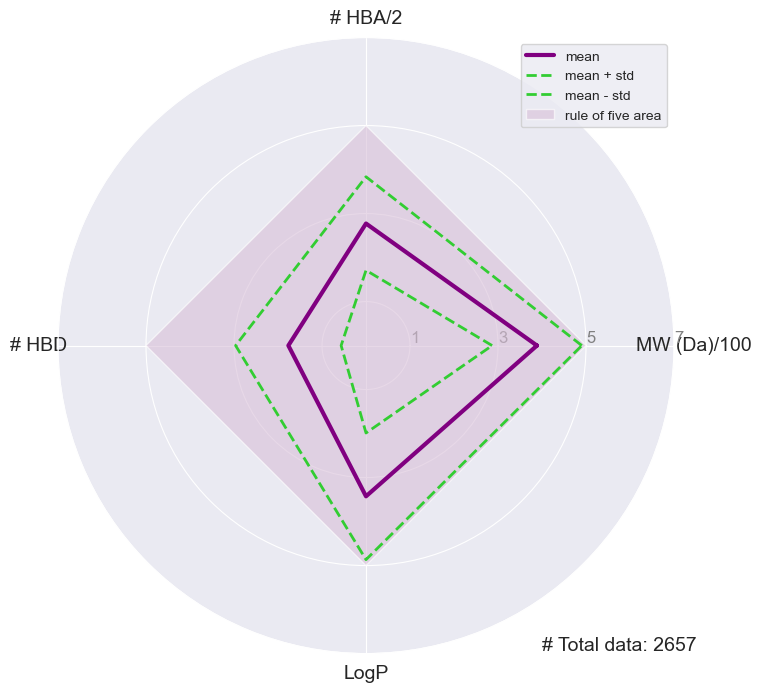

In [17]:
# Trazamos el radarplot para el conjunto de datos de compuestos (TODOS).
plot_radar(df_molecule)

### Radar plot - Rof confort: SÍ
Ahora vamos a repetir el proceso, pero solo con las moléculas que pasaron la prueba de la regla de cinco.
Primero debemos filtrar el conjunto `rule_of_five_conform: yes`

In [18]:
df_molecule_Ro5_yes = df_molecule[df_molecule['rule_of_five_conform']=='yes']
df_molecule_Ro5_yes.reset_index(inplace=True, drop=True)
# conjunto de datos que si cumplen la regla
df_molecule_Ro5_yes

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,392.196074,8,0,1.9610,yes
...,...,...,...,...,...,...,...,...,...
2472,CHEMBL3986013,3.49,O=C1Nc2ncccc2N[C@H]1Cc1c[nH]c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,278.116761,3,3,2.5382,yes
2473,CHEMBL48082,3.46,Nc1nccc(-c2c[nH]c3ccccc23)n1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,210.090546,3,2,2.2071,yes
2474,CHEMBL50226,3.38,Nc1nccc(-c2cc3ccccc3[nH]2)n1,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,210.090546,3,2,2.2071,yes
2475,CHEMBL2207943,3.32,CN1C(=O)CC(c2cccs2)Sc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,275.043856,3,0,3.9480,yes


Trazamos el radarplot para el conjunto de datos filtrado

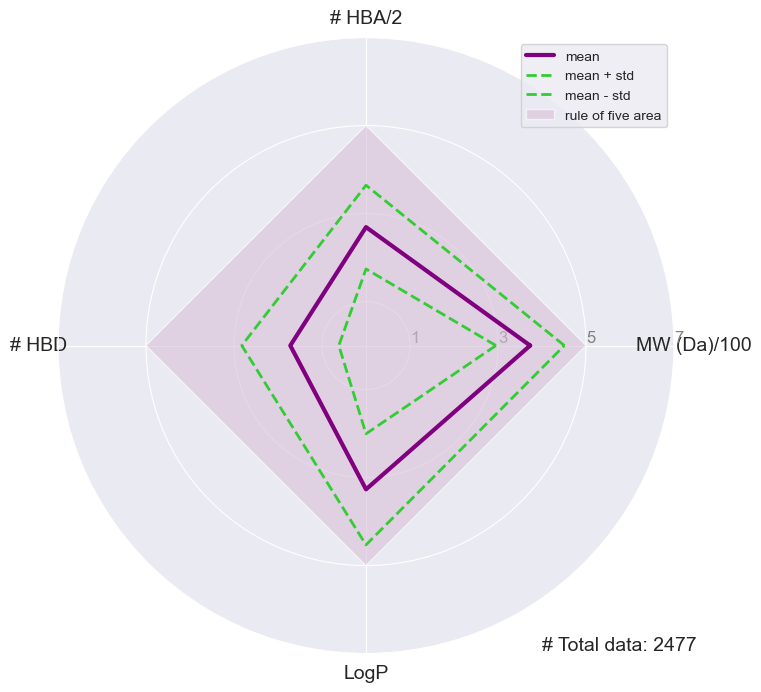

In [19]:
plot_radar(df_molecule_Ro5_yes)

## Radar plot - Rof confort: NO
Ahora vamos a repetir el proceso, pero solo con las moléculas que pasaron la prueba de la regla de cinco.
Primero debemos filtrar el conjunto `rule_of_five_conform: no`

In [20]:
df_molecule_Ro5_no = df_molecule[df_molecule['rule_of_five_conform']=='no']
df_molecule_Ro5_no.reset_index(inplace=True, drop=True)
df_molecule_Ro5_no

,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL1684800,8.56,COc1ccc(Cn2ncc(NC(=O)c3cc(NC(=O)Nc4ccc(Cl)c(C(...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,572.155051,6,4,6.39912,no
1,CHEMBL1231352,8.52,CN(C)c1nc2ccc1CCCCn1cc(c3ccccc31)C1=C(C(=O)NC1...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,543.263425,6,1,5.59330,no
2,CHEMBL3647956,8.30,N#Cc1sc(NCCNc2nc(-c3ccc(Cl)cc3Cl)cn3nc(C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,545.055212,11,5,2.95188,no
3,CHEMBL247067,8.15,CN(C)c1cc2cc(n1)CCCn1cc(c3ccccc31)C1=C(C(=O)NC...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,529.247775,6,1,5.20320,no
4,CHEMBL3647954,8.10,CCOC(=O)c1cc2c(N3CCCC(Nc4nc(N)c(C(C)=O)s4)C3)n...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAB...,573.111664,11,2,5.20200,no
...,...,...,...,...,...,...,...,...,...
175,CHEMBL5081821,4.04,Cn1c(NCCCCCCCNc2c3c(nc4cc(Br)ccc24)CCCC3)nc(-c...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,592.196150,7,2,6.64540,no
176,CHEMBL5073240,4.02,Cn1c(NCCCCCCCNc2c3c(nc4ccc(F)cc24)CCCC3)nc(-c2...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,532.276216,7,2,6.02200,no
177,CHEMBL451532,4.00,C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,580.179206,14,8,-1.16520,no
178,CHEMBL4294709,4.00,NC(=O)c1ccccc1CN1C(=O)CC(c2ccc(C(=O)NCc3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x0000025BBAA...,521.177313,4,2,5.48580,no


Trazamos el diagrama de radar para el conjunto de datos de compuestos que violan el Ro5

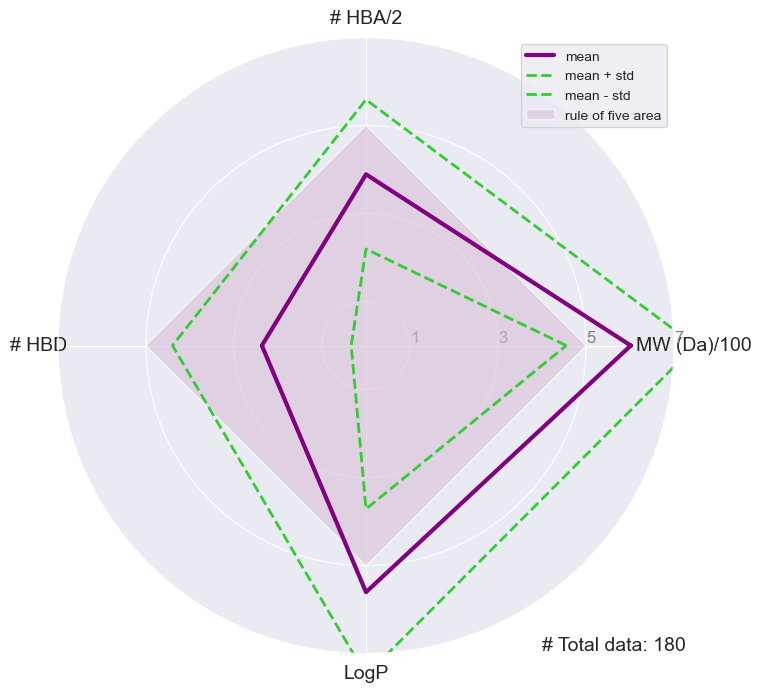

In [21]:
plot_radar(df_molecule_Ro5_no)

## Actividad práctica

Teniendo en cuenta lo aprendido en este Cuaderno, responde:
1. ¿Cómo puedes hacer un gráfico de barras para el conjunto de datos completo?
2. ¿Cómo puedes hacer un diagrama de dispersión para el conjunto de datos que cumpla con la regla de cinco?

## Conclusión

En esta práctica, hemos aprendido sobre la regla de cinco de Lipinski como una medida para estimar la biodisponibilidad oral de un compuesto y hemos aplicado la regla en un conjunto de datos. Además, aprendemos diferentes gráficos que permiten visualizar cómo se encuentra el conjunto de datos con respecto a la regla de cinco.